<a href="https://colab.research.google.com/github/Saadman53/Thesis-Human-Activity-Recognition/blob/main/Sensor%20Data%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
#gdrive_path = "drive/My Drive/Dataset/all_data.csv"
gdrive_path = "drive/My Drive/Dataset/sensor_data_preprocessed_nan_gyro.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install minepy
!pip install sklearn_relief
!pip install sklearn-genetic
!pip install info_gain
!pip install ax-platform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from minepy import MINE
from sklearn.feature_selection import mutual_info_regression
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from scipy.special import entr
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import differential_entropy
from scipy.stats import entropy
import scipy.io as sio

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.optim as optim
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate


from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from genetic_selection import GeneticSelectionCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import mutual_info_regression
from info_gain import info_gain

import random
from sklearn.metrics import confusion_matrix, recall_score, precision_score


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report


from torch.utils.data import DataLoader, ConcatDataset
# from torchvision import transforms
from sklearn.model_selection  import StratifiedKFold
%matplotlib inline

In [12]:
df = pd.read_csv(gdrive_path)
df.tail()

,0_mean_a_x,0_mean_a_y,0_mean_a_z,0_mean_a_m,0_var_a_x,0_var_a_y,0_var_a_z,0_var_a_m,0_std_a_x,0_std_a_y,...,9_min_xas_g_y,9_min_xas_g_z,9_min_xas_g_m,9_min_max_xas_g_x,9_min_max_xas_g_y,9_min_max_xas_g_z,9_min_max_xas_g_m,mat_filename,filename,activity
1160,-0.262760,0.049628,0.222775,0.035156,-0.696045,0.731201,371936.218386,6.434845e+07,2.152059,0.580166,...,2.992244,0.391365,9.763734e-11,2.494789e-10,0.625592,0.000010,0.000016,zyh_a22_t5.mat,zyh_a22_t5,22
1161,-0.293368,0.052936,0.230078,0.220947,-0.800293,1.021240,408638.128240,8.107497e+07,2.126449,0.511186,...,2.588938,0.483618,3.130640e-10,6.473369e-10,0.695427,0.000018,0.000025,zyh_a22_t6.mat,zyh_a22_t6,22
1162,-0.328229,0.057713,0.240234,0.035400,-0.851074,0.886474,599021.977566,1.584268e+08,2.114252,0.503679,...,3.116362,0.411375,1.965916e-10,4.778891e-10,0.641385,0.000014,0.000022,zyh_a22_t7.mat,zyh_a22_t7,22
1163,-0.324693,0.050767,0.225314,-0.005859,-0.778320,0.772461,641629.966089,1.718775e+08,2.205948,0.365290,...,3.488557,0.303883,1.035890e-10,3.408849e-10,0.551255,0.000010,0.000018,zyh_a22_t8.mat,zyh_a22_t8,22
1164,-0.283808,0.045411,0.213100,0.023193,-0.713867,0.737060,433162.917818,8.446987e+07,2.234118,0.549912,...,3.184521,0.400774,5.540869e-11,1.382544e-10,0.633067,0.000007,0.000012,zyh_a22_t9.mat,zyh_a22_t9,22


In [13]:
df['mat_filename'] = [x.replace(" ","") for x in df['mat_filename'] ]

In [14]:
df.drop(['filename'], axis = 1, inplace = True)

In [15]:
df.drop(df.columns[df.isna().any()].tolist(), axis = 1, inplace = True)
# df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [16]:
df = df.drop(983, inplace = False)
X = df.drop(['activity'], axis = 1)
y = df['activity']-1
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42, stratify = y)
train_files = X_train['mat_filename'].values
test_files = X_test['mat_filename'].values
X_train.drop(['mat_filename'], axis = 1,inplace = True)
X_test.drop(['mat_filename'], axis = 1,inplace = True)

X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train,test_size=0.15, random_state=42, stratify = y_train)

In [17]:
features = X_train.columns

In [18]:
#relief f
from sklearn.metrics.pairwise import pairwise_distances
def reliefF(X, y, **kwargs):
    """
    This function implements the reliefF feature selection
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    kwargs: {dictionary}
        parameters of reliefF:
        k: {int}
            choices for the number of neighbors (default k = 5)
    Output
    ------
    score: {numpy array}, shape (n_features,)
        reliefF score for each feature
    Reference
    ---------
    Robnik-Sikonja, Marko et al. "Theoretical and empirical analysis of relieff and rrelieff." Machine Learning 2003.
    Zhao, Zheng et al. "On Similarity Preserving Feature Selection." TKDE 2013.
    """

    if "k" not in kwargs.keys():
        k = 5
    else:
        k = kwargs["k"]
    n_samples, n_features = X.shape

    # calculate pairwise distances between instances
    distance = pairwise_distances(X, metric='manhattan')

    score = np.zeros(n_features)

    # the number of sampled instances is equal to the number of total instances
    for idx in range(n_samples):
        near_hit = []
        near_miss = dict()

        self_fea = X[idx, :]
        c = np.unique(y).tolist()

        stop_dict = dict()
        for label in c:
            stop_dict[label] = 0
        del c[c.index(y[idx])]

        p_dict = dict()
        p_label_idx = float(len(y[y == y[idx]]))/float(n_samples)

        for label in c:
            p_label_c = float(len(y[y == label]))/float(n_samples)
            p_dict[label] = p_label_c/(1-p_label_idx)
            near_miss[label] = []

        distance_sort = []
        distance[idx, idx] = np.max(distance[idx, :])

        for i in range(n_samples):
            distance_sort.append([distance[idx, i], int(i), y[i]])
        distance_sort.sort(key=lambda x: x[0])

        for i in range(n_samples):
            # find k nearest hit points
            if distance_sort[i][2] == y[idx]:
                if len(near_hit) < k:
                    near_hit.append(distance_sort[i][1])
                elif len(near_hit) == k:
                    stop_dict[y[idx]] = 1
            else:
                # find k nearest miss points for each label
                if len(near_miss[distance_sort[i][2]]) < k:
                    near_miss[distance_sort[i][2]].append(distance_sort[i][1])
                else:
                    if len(near_miss[distance_sort[i][2]]) == k:
                        stop_dict[distance_sort[i][2]] = 1
            stop = True
            for (key, value) in stop_dict.items():
                    if value != 1:
                        stop = False
            if stop:
                break

        # update reliefF score
        near_hit_term = np.zeros(n_features)
        for ele in near_hit:
            near_hit_term = np.array(abs(self_fea-X[ele, :]))+np.array(near_hit_term)

        near_miss_term = dict()
        for (label, miss_list) in near_miss.items():
            near_miss_term[label] = np.zeros(n_features)
            for ele in miss_list:
                near_miss_term[label] = np.array(abs(self_fea-X[ele, :]))+np.array(near_miss_term[label])
            score += near_miss_term[label]/(k*p_dict[label])
        score -= near_hit_term/k
    return score


def feature_ranking(score):
    """
    Rank features in descending order according to reliefF score, the higher the reliefF score, the more important the
    feature is
    """
    idx = np.argsort(score, 0)
    return idx[::-1]
def selected_features(X, score):
  ranked_features = feature_ranking(score)
  sel_feat = []
  for i in range(X.shape[1]):
    if(ranked_features[i]>0):
      sel_feat.append(ranked_features[i])
    else:
      break
  return X.columns[np.array(sel_feat)]


In [23]:
print(X_train_val.shape, y_train_val.shape)

(691, 1200) (691,)


In [24]:
##symmetrical uncertainty
def SU(df, X,Y):
  if(Y=='activity'):
    IG = mutual_info_classif(np.transpose(np.array([df[X]])), df[Y]).item()
    H_Y = entropy(df[Y])
  else:
    IG = mutual_info_regression(np.transpose(np.array([df[X]])), df[Y]).item()
    H_Y = differential_entropy(df[Y])
  H_X = differential_entropy(df[X])
  su = ((2.0*IG)/(H_X+H_Y))
  return su
 
def MI(df, X,Y):
  if(Y=='activity'):
    MI = mutual_info_classif(np.transpose(np.array([df[X]])), df[Y]).item()
  else:
    MI = mutual_info_regression(np.transpose(np.array([df[X]])), df[Y]).item()
  return MI

def MIC_feature_selection(X_train, y_train):
  scores = {}
  mine = MINE(alpha=0.6, c=15, est="mic_approx")
  for i in range(X_train.shape[1]):
    mic_score = mine.compute_score(X_train.iloc[:,i], y_train).mic()
    scores.append(mic_score)
    res = pd.Series(np.array(scores),index = features).sort_values(ascending=False)
  return res
# res[res>0.60].index.values

def SU_feature_selection(X_train, y_train):
  df_train = df[X_train.columns].iloc[X_train.index].copy()
  scores = []
  #print("SU:\nCol\tScore")
  for col in df_train.columns:
    if col!='activity':
      #print(col+":")
      score = SU(df, col, 'activity')
      scores.append(score)
      #print(score)
  ser = pd.Series(np.array(scores),index = features).sort_values(ascending=False)
  return ser[ser>0.0].index.values

#Fast Correlation Based Filter
def FCBF(df, features, C):
  thresh = 0.000001
  N = len(features)
  S_list = {}
  for i in range(N):
    val = SU(df, features[i], C)
    if(val> thresh):
      S_list[features[i]] = val
  S_list = pd.Series(S_list).sort_values(ascending=False)
  no_features = S_list.shape[0]
  a_list = np.ones(no_features)
  for i in range(no_features):
    if(a_list[i]==1):
      Fp = S_list.index[i]
      for j in range(i+1,no_features):
        if(a_list[j]==1):
          Fq = S_list.index[j]
          if(SU(df, Fp,Fq) >= S_list[j]):
            #print(f"{j} has been eleminated while in {i}")
            a_list[j]=0
  idx = np.where(a_list==1)[0]
  return S_list.index[idx]

def random_forest_feature_selection(X_train, y_train):
  sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
  sel.fit(X_train, y_train)
  sel.get_support()
  selected_features_rf= X_train.columns[(sel.get_support())].values
  return selected_features_rf

def reliefF_feature_selection(X_train, y_train):
  score = reliefF(X_train.to_numpy(),y_train.to_numpy())
  selected_features_relief = selected_features(X_train,score).values
  return selected_features_relief

def genetic_feature_selection(X_train, y_train):
  estimator = DecisionTreeClassifier()
  model = GeneticSelectionCV(
      estimator, cv=5, verbose=0,
      scoring="accuracy", max_features=100,
      n_population=100, crossover_proba=0.5,
      mutation_proba=0.2, n_generations=50,
      crossover_independent_proba=0.5,
      mutation_independent_proba=0.04,
      tournament_size=3, n_gen_no_change=10,
      caching=True, n_jobs=-1)
  model = model.fit(X_train,y_train)
  selected_features_genetic = X_train.columns[model._get_support_mask()].values
  return selected_features_genetic

def mutual_information_feature_selection(X_train, y_train):
  mi_scores = mutual_info_regression(X_train, y_train, discrete_features=False)
  mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  selected_features_info_gain = mi_scores[mi_scores>0.5].index.values
  return selected_features_info_gain

def information_gain_feature_selection(X_train, y_train):
  scores = []
  for i in range(X_train.shape[1]):
    score = info_gain.info_gain(X_train.iloc[:,i], y_train )
    scores.append(score)
    #print(X_train.columns[i],score) [res>0.60].index.values
  res = pd.Series(np.array(scores),index = features).sort_values(ascending=False)
  return res[res>3.0].index.values
def gain_ratio_feature_selection(X_train, y_train):
  gain_ratio = []
  #print("Gain Ratio:\nCol\tScore")
  for i in range(X_train.shape[1]):
    score = info_gain.info_gain_ratio(X_train.iloc[:,i], y_train )
    gain_ratio.append(score)
    #print(X_train.columns[i],score)
  res = pd.Series(np.array(gain_ratio),index = features).sort_values(ascending=False)
  return res[res>0.60].index.values

def chi2_feature_selection(X_train,y_train):
  scaler = MinMaxScaler()
  X_train1 = scaler.fit_transform(X_train)
  from sklearn.feature_selection import chi2
  chi_scores = chi2(X_train1,y_train)
  p_values = pd.Series(chi_scores[1],index = X_train.columns)
  p_values.sort_values(ascending = False , inplace = True)
  selected_features_chi = p_values[p_values>0.5].index.values
  return selected_features_chi

In [25]:
def ECFS(df,X_train,y_train):
  selected_feature_list = [random_forest_feature_selection(X_train,y_train),
                           reliefF_feature_selection(X_train,y_train), 
                           genetic_feature_selection(X_train,y_train), 
                           mutual_information_feature_selection(X_train,y_train), 
                           chi2_feature_selection(X_train,y_train)]
  s = set()
  df_train = df.iloc[X_train.index]
  for i in range(5):
    for j in range(len(selected_feature_list[i])):
      s.add(selected_feature_list[i][j])
  final_list = []
  ensemble_list = []
  for feat in s:
    cnt = 0
    for j in range(5):
      if(feat in selected_feature_list[j]):
        cnt+=1
    if(cnt>=4):
      final_list.append(feat)
    else:
      ensemble_list.append(feat)
  sel = FCBF(df_train, ensemble_list, 'activity')
  final_list.extend(sel.values.tolist())
  return final_list

In [28]:
selected_feat_ecfs = ECFS(df, X_train, y_train)
len(selected_feat_ecfs)

431

In [29]:
sensor_features = {'train_filename':train_files, 'test_filename': test_files, 'X_train': X_train[selected_feat_ecfs].to_numpy(), 'X_test': X_test[selected_feat_ecfs].to_numpy()}
sio.savemat("drive/My Drive/Dataset/sensor_features_acc_gyro.mat",sensor_features)

In [ ]:
def EFS_MI(df, X_train, y_train):
  selected_feature_list = [gain_ratio_feature_selection(X_train, y_train),
                           reliefF_feature_selection(X_train,y_train), 
                           SU_feature_selection(X_train, y_train), 
                           information_gain_feature_selection(X_train, y_train), 
                           chi2_feature_selection(X_train,y_train)]
  s = set()
  df_train = df.iloc[X_train.index]
  for i in range(5):
    for j in range(len(selected_feature_list[i])):
      s.add(selected_feature_list[i][j])
  optimal_list = []
  ensemble_list = []
  for feat in s:
    cnt = 0
    for j in range(5):
      if(feat in selected_feature_list[j]):
        cnt+=1
    if(cnt==5):
      optimal_list.append(feat)
    else:
      ensemble_list.append(feat)
  f_class_mi = []
  for feature in ensemble_list:
    score = MI(df_train, feature, 'activity')
    f_class_mi.append(score)
  f_class_mi = pd.Series(np.array(f_class_mi),index = ensemble_list).sort_values(ascending=False)
  ensemble_list= f_class_mi.index.values
  #print(len(optimal_list))
  #print(len(ensemble_list))
  for feature in ensemble_list:
    scores = []
    for opt_feature in optimal_list:
      scores.append(MI(df_train,feature,opt_feature))
    if (max(scores)<0.75):
      optimal_list.append(feature)
  return optimal_list


In [ ]:
selected_feat_efs_mi = EFS_MI(df, X_train, y_train)
len(selected_feat_efs_mi)

365

In [30]:
class DNN(nn.Module):
    def __init__(self,input_size,output_size):
        super(DNN,self).__init__()
        self.hidden1 = nn.Linear(input_size,128)
        self.hidden2 = nn.Linear(128,64)
        self.hidden3 = nn.Linear(64,32)
        self.output = nn.Linear(32,output_size)
        self.softmax = F.softmax
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(32)
    
    def forward(self,x):
        out = self.hidden1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        
        out = self.hidden2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.hidden3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.output(out)
        return out

In [31]:
def train_test_loader(X_train, X_test, y_train, y_test, selected_features):
  scaler = MinMaxScaler()
  train_X = X_train[selected_features].copy()
  test_X = X_test[selected_features].copy()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)
  train_dataset = TensorDataset(Tensor(train_X), Tensor(y_train.values))
  test_dataset = TensorDataset(Tensor(test_X), Tensor(y_test.values))
  test_loader = DataLoader(test_dataset, batch_size= 64)
  return train_dataset, test_loader

train_set, test_loader = train_test_loader(X_train, X_test, y_train, y_test, selected_feat_ecfs)

In [32]:
def net_train(net, train_loader, parameters):
  criterion = nn.CrossEntropyLoss(reduction = "sum")
  optimizer = optim.SGD(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9)
  )

  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=1.0,  # default is no learning rate decay
  )

  num_epochs = parameters.get("max_epoch", 3) # Play around with epoch number
  # Train Network
  for _ in range(num_epochs):
    for inputs, labels in train_loader:
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels.long())
      loss.backward()
      optimizer.step()
      scheduler.step()
  return net

In [38]:
def train_evaluate(parameterization):
    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(train_set,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=0,
                                pin_memory=True)
    
    # Get neural net
    untrained_net = DNN(inpsize,22)
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization)
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=test_loader,
        dtype = torch.float,
        device = "cpu"
    )

In [42]:
train_set, test_loader = train_test_loader(X_train_val, X_val, y_train_val, y_val, selected_feat_ecfs)
inpsize = len(selected_feat_ecfs)

dtype = torch.float
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        {"name": "batchsize", "type": "range", "bounds": [16, 128]},
        {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},    
        {"name": "max_epoch", "type": "range", "bounds": [1, 100]},
        {"name": "stepsize", "type": "range", "bounds": [20, 40]},     
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 02-03 07:31:57] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-03 07:31:57] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batchsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-03 07:31:57] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-03 07:31:57] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_epoch. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter di

{'lr': 0.0008183927205785369, 'batchsize': 52, 'momentum': 0.3137449534094986, 'max_epoch': 41, 'stepsize': 36}
{'accuracy': 1.0030961099752602}
{'accuracy': {'accuracy': 4.321524759371776e-05}}


In [43]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])

best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

render(plot_contour(model=model, param_x='batchsize', param_y='lr', metric_name='accuracy'))

In [41]:
data = experiment.fetch_data()
dff = data.df
best_arm_name = dff.arm_name[dff['mean'] == dff['mean'].max()].values[0]
best_arm = experiment.arms_by_name[best_arm_name]
best_arm

Arm(name='0_0', parameters={'lr': 0.0011227892716609519, 'batchsize': 99, 'momentum': 0.014515183866024017, 'max_epoch': 62, 'stepsize': 33})

In [54]:
def optim_scheduler(net,parameters):
  optimizer = optim.SGD(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9)
  )
  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=1.0,  # default is no learning rate decay
  )
  return optimizer, scheduler
def extract_batch(X,y,batch_size,step,no_of_samples):
  l = (step-1)*batch_size
  return X[l:(l+batch_size)],y[l:min(no_of_samples,l+batch_size)]

def model_training_evaluation(X_train, X_test, y_train, y_test, selected_feat):
  train_X = X_train[selected_feat]
  test_X = X_test[selected_feat]
  scaler = MinMaxScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)
  train_X = torch.from_numpy(train_X.astype(np.float32))
  test_X = torch.from_numpy(test_X.astype(np.float32))
  train_y =  torch.tensor(y_train.values.astype(np.float32))
  test_y =  torch.tensor(y_test.values.astype(np.float32))
  input_size = train_X.shape[1]
  output_size = torch.unique(train_y).shape[0]
  learning_rate = best_parameters['lr']
  num_epochs = best_parameters['max_epoch']
  n_samples = train_X.shape[0]
  criterion = nn.CrossEntropyLoss(reduction='sum')
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
  net = DNN(input_size, output_size)
  optimizer, scheduler = optim_scheduler(net,best_parameters)
  figure, ax = plt.subplots(5,figsize=(10,10))
  figure.tight_layout(pad=5.0)
  cnt = 1
  best_loss = 100000
  best_model = None
  best_epoch = None
  for train_index, val_index in skf.split(X_train, y_train):
    train_X_fold = train_X[train_index]
    train_y_fold = train_y[train_index]
    val_x_fold = train_X[val_index]
    val_y_fold = train_y[val_index]
    n_samples = train_X_fold.shape[0]
    batch_size = int(n_samples/5)
    train_loss = []
    val_loss = []
    print(f"Training for fold {cnt}")
    for epoch in range(num_epochs):
      step = 1
      while(batch_size*step<=n_samples):
        x,y =  extract_batch(train_X_fold,train_y_fold, batch_size, step, n_samples)
        # Forward Propagation
        y_predicted = net(x)
        loss = criterion(y_predicted,  torch.tensor(y, dtype=torch.long))
        # Backward propagation and update
        loss.backward()
        optimizer.step()
        # Performing zero grad before new step
        optimizer.zero_grad()
        step = step+1
      t_loss = criterion( net(train_X_fold),  torch.tensor(train_y_fold, dtype=torch.long)).item()/train_X_fold.shape[0]
      v_loss = criterion( net(val_x_fold),  torch.tensor(val_y_fold, dtype=torch.long)).item()/val_x_fold.shape[0]
      train_loss.append(t_loss) 
      val_loss.append(v_loss)
      if(v_loss<best_loss):
        best_loss = v_loss
        best_model = net
        best_epoch = epoch
      print(epoch*100/num_epochs)
    m = "Fold "+str(cnt)
    ax[cnt-1].title.set_text(m)
    ax[cnt-1].set_ylabel("Total Loss")
    ax[cnt-1].set_xlabel("No of Epochs")
    ax[cnt-1].plot(range(num_epochs),train_loss, label = "train loss")
    ax[cnt-1].plot(range(num_epochs),val_loss, label = "validation loss")
    cnt+=1
  y_pred = best_model(test_X)
  return best_model, y_pred


Training for fold 1
0.0
2.4390243902439024
4.878048780487805
7.317073170731708
9.75609756097561
12.195121951219512
14.634146341463415
17.073170731707318
19.51219512195122
21.951219512195124
24.390243902439025
26.829268292682926
29.26829268292683
31.70731707317073
34.146341463414636
36.58536585365854
39.02439024390244
41.46341463414634
43.90243902439025
46.34146341463415
48.78048780487805
51.21951219512195
53.65853658536585
56.09756097560975
58.53658536585366
60.97560975609756
63.41463414634146
65.85365853658537
68.29268292682927
70.73170731707317
73.17073170731707
75.60975609756098
78.04878048780488
80.48780487804878
82.92682926829268
85.36585365853658
87.8048780487805
90.2439024390244
92.6829268292683
95.1219512195122
97.5609756097561
Training for fold 2
0.0
2.4390243902439024
4.878048780487805
7.317073170731708
9.75609756097561
12.195121951219512
14.634146341463415
17.073170731707318
19.51219512195122
21.951219512195124
24.390243902439025
26.829268292682926
29.26829268292683
31.70731

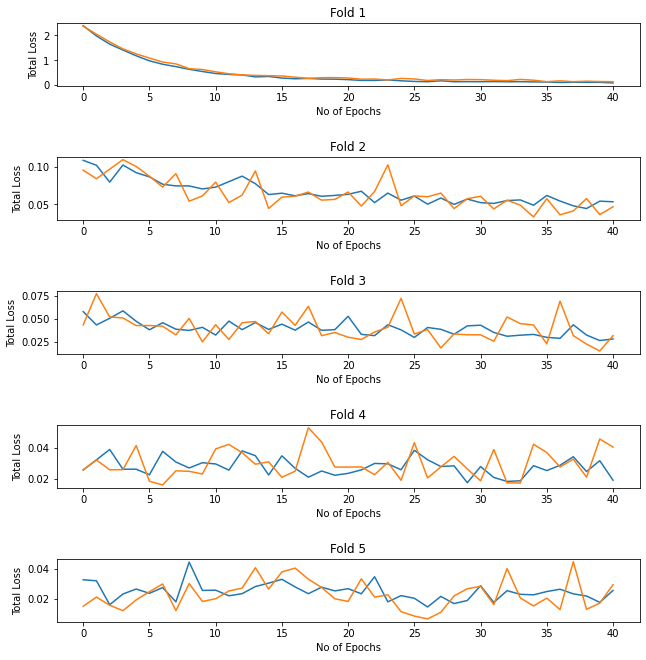

In [55]:
best_model, y_pred = model_training_evaluation(X_train, X_test, y_train, y_test, selected_feat_ecfs)

In [67]:
def cf_matrix(y_pred, test_y):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred = torch.max(y_pred_softmax, dim = 1)
  y_pred = y_pred.detach().numpy().ravel()
  correct_pred = (y_pred == test_y).astype(np.float)
  acc = correct_pred.sum()*100.0 / y_pred.shape[0]
  cm = confusion_matrix(test_y.ravel(), y_pred)
  recall = np.mean(recall_score(test_y.ravel(), y_pred, average=None))*100.0
  precision = np.mean(precision_score(test_y.ravel(), y_pred, average=None))*100.0
  f1 = 2*((precision*recall*1.0)/(precision+recall))
  f,ax=plt.subplots(figsize=(20,10))
  sns.heatmap(cm,annot=True,fmt='.0f', cmap="Blues")
  print(f"Accuracy: {acc:.2f}%")
  print(f"Precision: {precision:.2f}%")
  print(f"Recall: {recall:.2f}%")
  print(f"F1 score: {f1:.2f}%")
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()
  return cm,acc, recall, precision, f1


Accuracy: 97.43%
Precision: 97.52%
Recall: 97.42%
F1 score: 97.47%


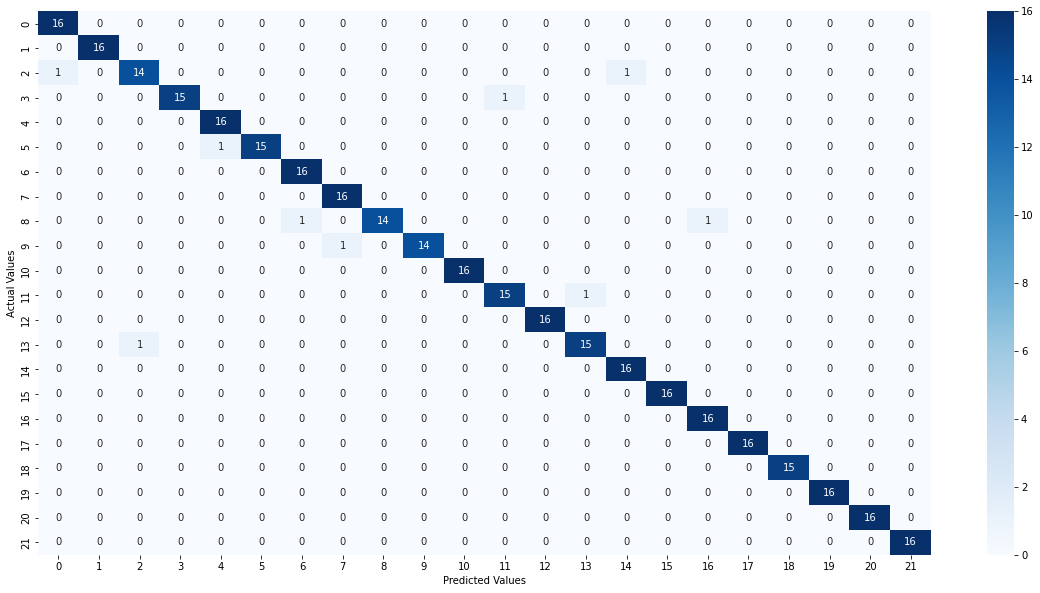

In [68]:
cm,acc, recall, precision,f1 = cf_matrix(y_pred, y_test)

Training for fold 1
Training for fold 2
Training for fold 3
Training for fold 1
Training for fold 2
Training for fold 3
Training for fold 1
Training for fold 2
Training for fold 3


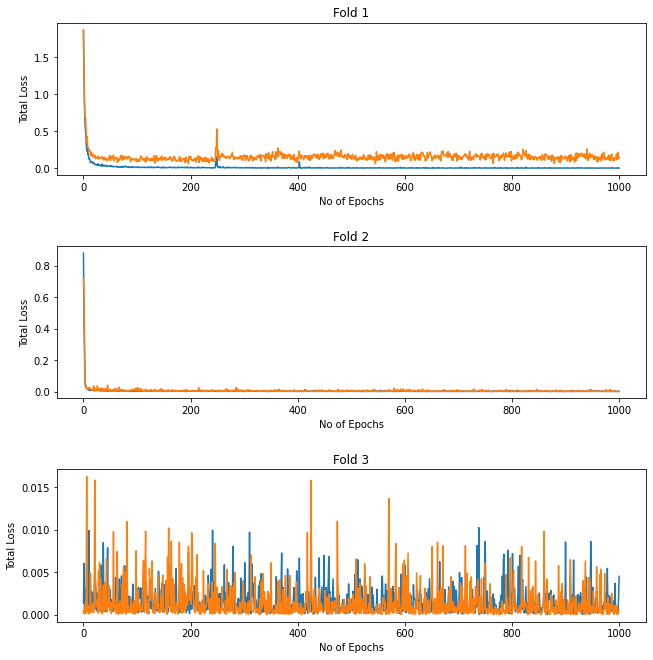

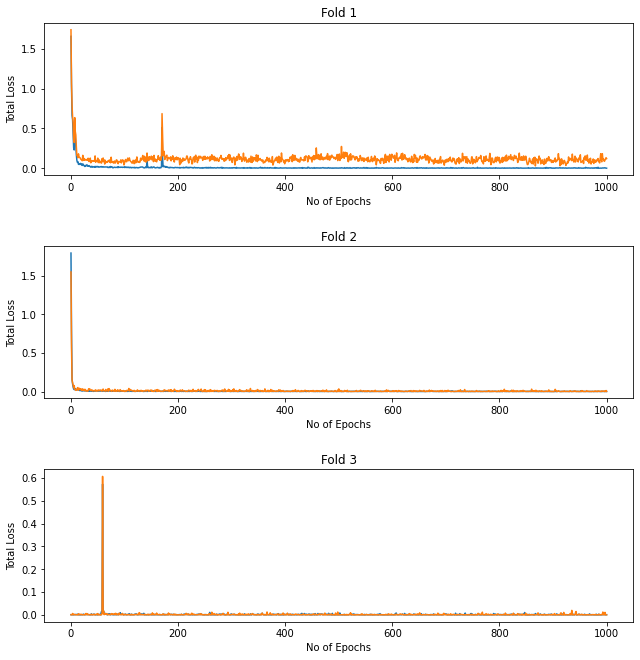

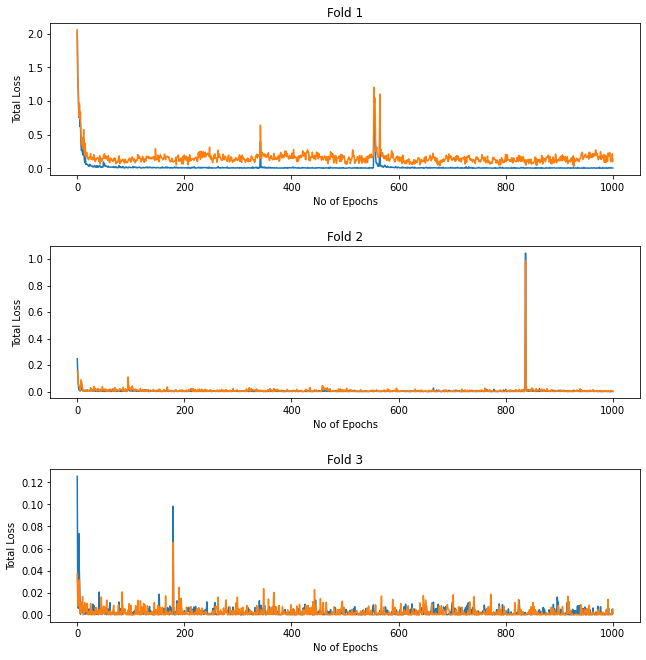

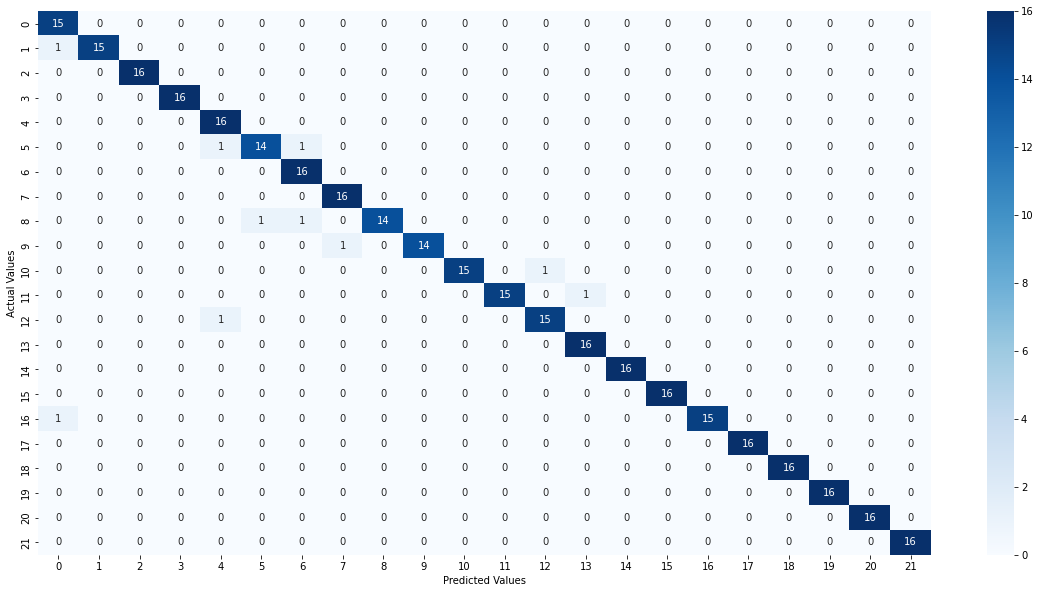

7.114334055995809e-06
Accuracy is 97.43%
Recall is 97.14%
Precision is 97.33%


(DNN(
   (hidden1): Linear(in_features=365, out_features=128, bias=True)
   (hidden2): Linear(in_features=128, out_features=64, bias=True)
   (hidden3): Linear(in_features=64, out_features=32, bias=True)
   (output): Linear(in_features=32, out_features=22, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.2, inplace=False)
   (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (batchnorm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ), tensor([[ -5.0981, -17.8475, -25.9509,  ...,   3.5870, -18.8044,  -6.7196],
         [ -0.3506, -15.7958, -16.1711,  ...,  15.8539, -11.4495, -13.9958],
         [-16.9967,   3.1327,  -3.2597,  ...,  -4.3378,  -7.5716, -10.2148],
         ...,
         [ 47.4946,  19.0682,   8.4017,  ..., -12.1267,   8.6317, -12.2513],
         [ -8.0307, -10.3419, -11.6558,  ...,  -8.451

In [ ]:
}#model training with hyperparameter tuning using features selected by existing EFS-MI algorithm
model_training_evaluation(X_train, X_test, y_train, y_test,selected_feat_efs_mi)

Training for fold 1
Training for fold 2
Training for fold 3
Training for fold 4
Training for fold 5
Training for fold 1
Training for fold 2
Training for fold 3
Training for fold 4
Training for fold 5
Training for fold 1
Training for fold 2
Training for fold 3
Training for fold 4
Training for fold 5


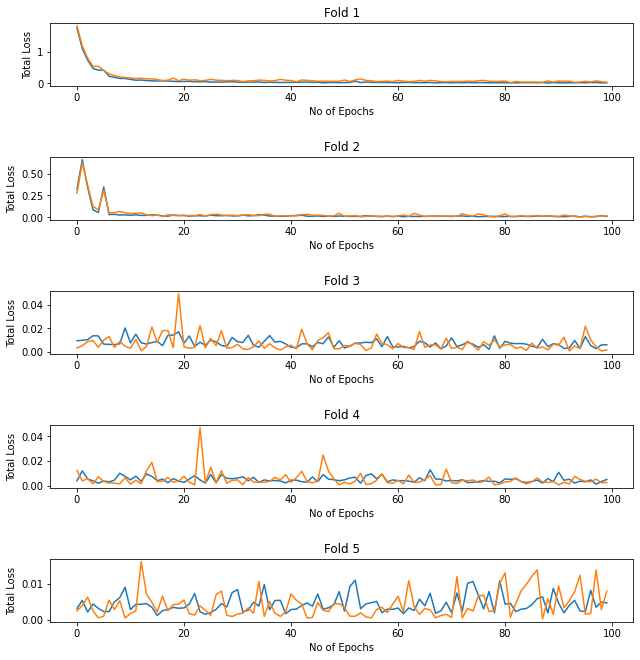

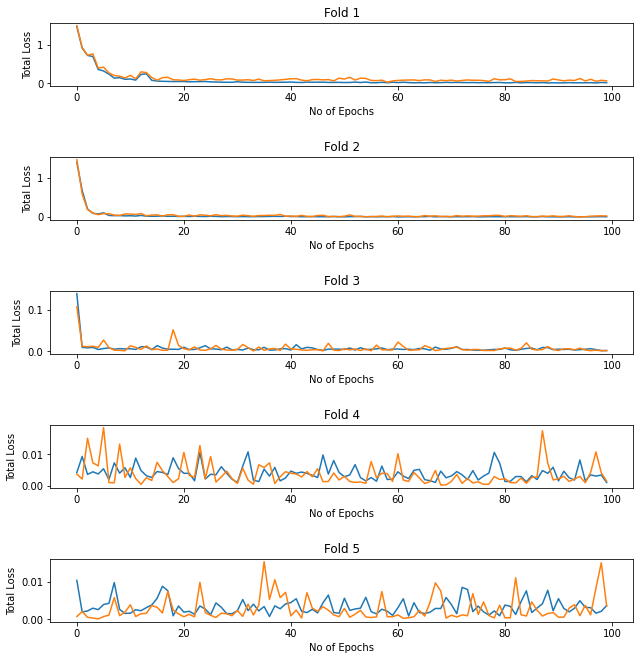

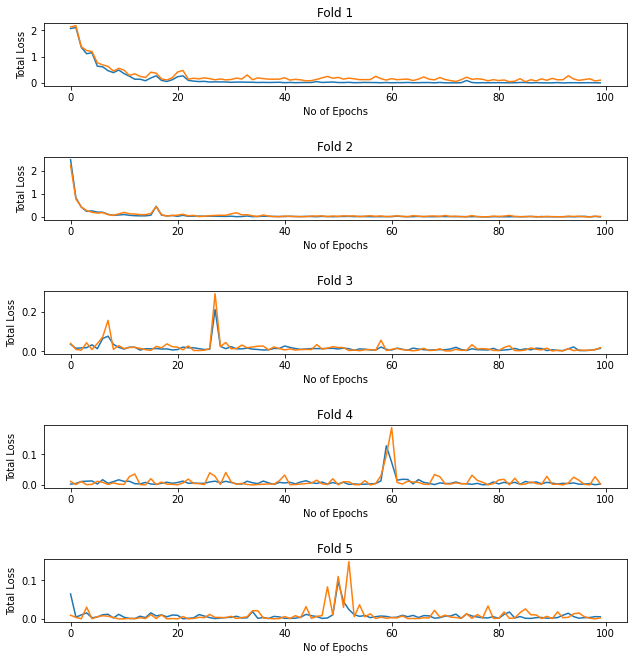

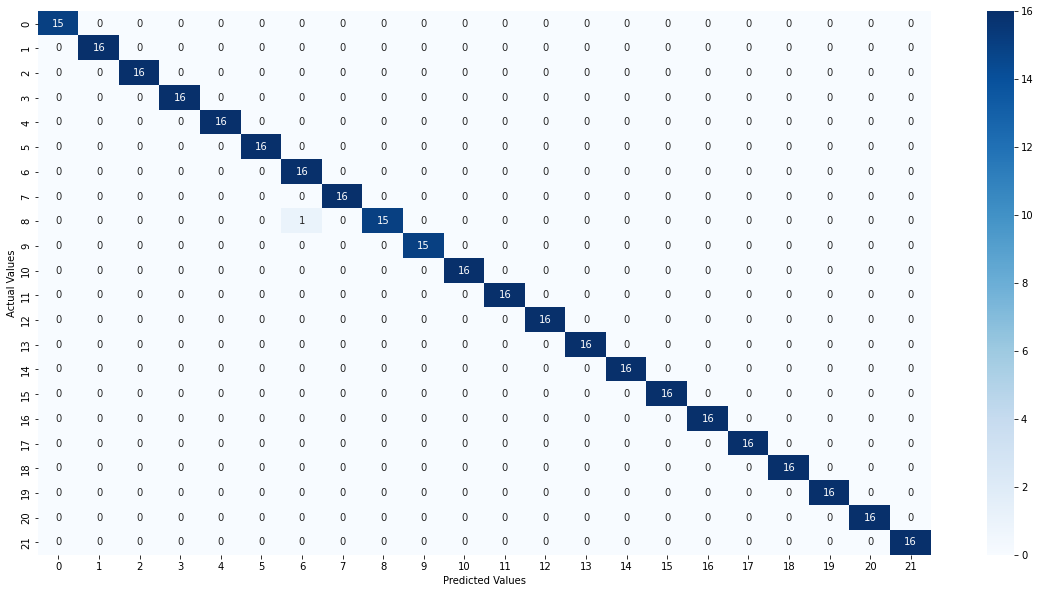

7.418808124867486e-05
Accuracy is 99.14%
Recall is 99.72%
Precision is 99.73%


In [32]:
# model training with hyperparameter tuning using features selected by proposed EBCFS algorithm
model, pred = model_training_evaluation(X_train, X_test, y_train, y_test,selected_feat_ecfs)
model_save_name = 'sensor_acc_gyro_DNN.pt'
# path = F"/content/drive/My Drive/Dataset/Models/{model_save_name}" 
# torch.save(model.state_dict(), path)